# Network Modeling

In this notebook, I will use computational techniques for studying properties of networks. These techniques will involve both the study of real world networks as well as computational simulation/modeling techniques.

## Prerequisites
I will be assuming some minimal knowledge of graph theory and familiarity with Python. If you know what directed/undirected graphs are, you should be fine. Otherwise, take a few minutes to read the wikipedia page <a href = "https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)">here</a>.

## Objectives
<ul>
<li> Learn how to construct/manipulate network representations of real world data </li>
<li> Obtain practical experience using NetworkX and other modeling techniques for graphs </li>
<li> Learn how to simulate dynamical systems on networks </li>
</ul>

## Software & Packages
You should have the following installed: `numpy`, `scipy`, `networkx`, `matplotlib`. If you've installed the package manager anaconda, all of them will be taken care of for you. To run the interactive simulations, you'll need to download the `pycxsimulator` package from <a href="http://pycx.sourceforge.net"> here</a> - downloading the file `pycxsimulator.py` is enough. This module also needs the `ttk` and `tkinter` modules to run, but it's likely you will already have them installed - if not, you should be able to use anaconda to set them up.

https://youtu.be/eCnK32m9oJE

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
from helpers import FileIO
graph = FileIO.read_dolphins();

/Users/Nitin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


All we've done so far is import the necessary libraries and read in the graph. Before we do any actual computation however, it's a good idea to visualize the data set.

We'll be using the fairly standard `matplotlib.pyplot` module for visualization. If you want to see documentation about how to use the library, here is the <a href = "http://matplotlib.org/api/pyplot_summary.html"> documentation</a>. 

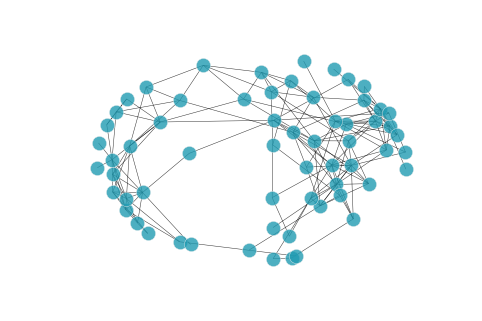

In [3]:
nx.draw_spring(graph, node_color='#209BB2', alpha = 0.8, node_size = 200, width = 0.5);

So now we've seen what the community looks like. Now let's examine some basic properties of the network. NetworkX already has most analytics built in, so we don't need to write much code to describe this network.

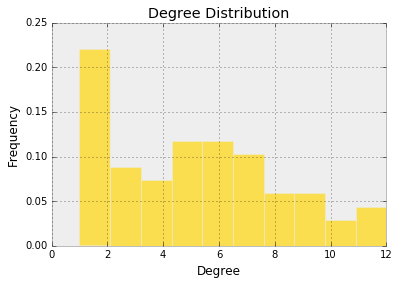

In [4]:
fig = plt.figure(); ax = fig.add_subplot(111); ax.set_xlabel('Degree'); 
ax.set_ylabel('Frequency'); ax.set_title('Degree Distribution');
ax.hist((nx.degree(graph)).values(), color = '#FFDA29', alpha = 0.8, align = 'mid', normed=True);

So we can see that the degree of the vertices varies from 1-12 with most vertices having small degree. But which ones are these? We can visualize the graph again, but specify attributes for the nodes to see which ones have large degree.

In [5]:
degrees = nx.degree(graph);
nx.set_node_attributes(graph, 'degree', degrees);

Drawing is a little more involved now, but not by much.

In [6]:
pos = nx.spring_layout(graph);
nodelist = range(1, nx.number_of_nodes(graph)+1);
degree_nodes = [float(graph.node[node]['degree'])/12.0 for node in nodelist]

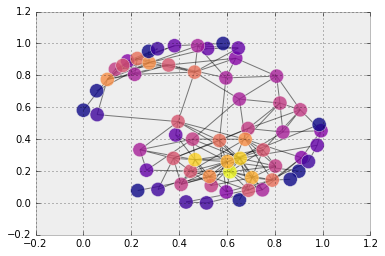

In [7]:
nx.draw_networkx_nodes(graph,pos, nodelist=nodelist, node_color=degree_nodes, node_size=200, 
                       cmap=plt.cm.plasma, alpha = 0.8)
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)


We can do something similar for any node attribute we want to visualize. Suppose we want to determine the nodes that rank high for "in-betweeness." This is a metric that calculates the proportion of vertex pairs shortest paths that use node $v$ as a hub.

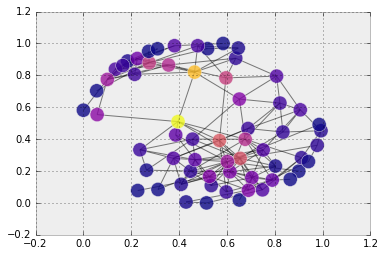

In [8]:
betweeness = nx.betweenness_centrality(graph);
bb_data = [float(betweeness[node]) for node in nodelist];
nx.draw_networkx_nodes(graph, pos, nodelist=nodelist, node_color=bb_data, node_size=200, 
                       cmap=plt.cm.plasma, alpha = 0.8)
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

In the next stage, we're going to compute the random walk centrality. A node has high centrality with this method if a large proportion of random walks between vertices use that node.


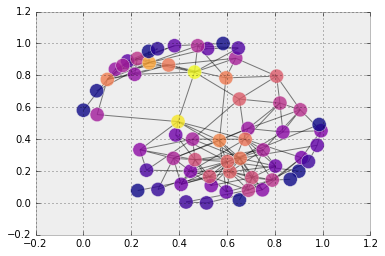

In [9]:
rw_cent = nx.current_flow_betweenness_centrality(graph);
rw_centrality = [float(rw_cent[node]) for node in nodelist];
nx.draw_networkx_nodes(graph, pos, nodelist=nodelist, node_color=rw_centrality, node_size=200, 
                       cmap=plt.cm.plasma, alpha = 0.8)
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

It turns out that because of this network structure, both "betweeness" metrics give similar results.

## Network Dynamics
In this section, we'll turn our attention to simulating dynamical systems on networks. Dynamical systems loosely refer to systems that deal with processes over time. While the canonical example is a system of differential equations, we can also have discrete dynamical systems, which is what we'll be working with today.

We're going to define a simulation class that will take in a function for applying a network rule. This will allow us to construct a general simulation class that can model a variety of different dynamical system models, including epidemic modeling, voter agreement circles, and clustering rules. We'll limit our experimentation to epidemic modeling however.

Some code was taken from <i>Modeling and Analysis of Complex Systems</i>, which you can download for free <a href= "http://textbooks.opensuny.org/introduction-to-the-modeling-and-analysis-of-complex-systems/"> here</a>. All the code is placed in the file `helpers.py`, since we also want to be able to visualize the simulation in the desktop - unfortunately, iPython is only good for static visualizations.

In [10]:
from helpers import SimulatorAsync, Epidemic
sim = SimulatorAsync(graph, Epidemic.randomized_infection(0.1), 
                     Epidemic.randomized_update(0.2, 0.3))
sim.run_simulation(steps = 2000);

In [11]:
len(sim.marked)

26

Unfortuantely, this procedure will work for generating and recording Monte Carlo style simulations, but not very well for visualizing them. To actually see how this simulation works, we'll need to leave the iPython notebook and work out of our console.

https://www.youtube.com/watch?v=34iorSNp58A

Take a look at the file `simulation.py`. If you have all necessary packages installed, you should be able to run `python simulation.py` right from your command line and a GUI will pop up with the image of the graph. Hit run, and you should see the dynamics of the network changing.

## Monte Carlo Simulation
Great, so now we know what this model looks like and how it behaves for certain parameter values. But what's the point?

The point is that using this general framework we can generate large numbers of simulations and compare the empirical distributions to see how parameter choice affects behavior as a whole.

In [21]:
from helpers import SimulatorAsync, Epidemic
from helpers import FileIO
graph = FileIO.read_dolphins();
class MCSim:
    @staticmethod
    def perform_trial(initial, transmission, recover):
        sim = SimulatorAsync(graph, Epidemic.randomized_infection(initial), 
                     Epidemic.randomized_update(transmission, recover))
        sim.run_simulation(steps = 2000);
        return len(sim.marked);
    
    @staticmethod
    def extinct_trials(trials, initial, transmission, recover):
        extinct = 0;
        for i in range(trials):
            length = MCSim.perform_trial(initial, transmission, recover);
            if length == 0:
                extinct+=1;
        return float(extinct)/float(trials);
    
    @staticmethod
    def perform_simulation(trials, initial, transmission_rng, recover_rng):
        all_results = [];
        for tr in transmission_rng:
            recover_results = [];
            for r in recover_rng:
                e_pr = MCSim.extinct_trials(trials, initial, tr, r);
                recover_results.append(e_pr);
            print recover_results;
            all_results.append(recover_results);
        return np.array(all_results);
    

In [22]:
test = MCSim.extinct_trials(100, 0.1, 0.2, 0.3)

In [28]:
tr_rng = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,  0.6, 0.65, 0.7, 0.75, 0.8];
rec_rng = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,  0.6, 0.65, 0.7, 0.75, 0.8];

In [29]:
results = MCSim.perform_simulation(100, 0.1, tr_rng, rec_rng);

[0.01, 0.07, 0.11, 0.34, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.01, 0.02, 0.02, 0.12, 0.22, 0.6, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.01, 0.05, 0.07, 0.19, 0.62, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.01, 0.0, 0.02, 0.03, 0.03, 0.08, 0.15, 0.59, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.04, 0.02, 0.07, 0.03, 0.09, 0.22, 0.77, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.01, 0.01, 0.01, 0.01, 0.0, 0.04, 0.09, 0.16, 0.44, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.02, 0.0, 0.01, 0.01, 0.01, 0.05, 0.02, 0.09, 0.17, 0.6, 0.98, 1.0, 1.0, 1.0, 1.0]
[0.01, 0.01, 0.0, 0.01, 0.02, 0.01, 0.07, 0.11, 0.08, 0.45, 0.89, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.09, 0.08, 0.16, 0.2, 0.72, 0.99, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.0, 0.0, 0.03, 0.05, 0.06, 0.06, 0.12, 0.24, 0.66, 0.98, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.04, 0.01, 0.03, 0.1, 0.1, 0.16, 0.41, 0.94, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.02, 0.01, 0.04, 0.06, 0.07, 0.13, 0.32, 0.65, 1.0, 1.0, 1.0

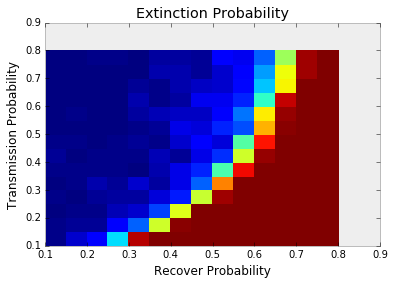

In [31]:
fig = plt.figure(); ax = fig.add_subplot(111); ax.set_xlabel('Recover Probability'); 
ax.set_ylabel('Transmission Probability'); ax.set_title('Extinction Probability');
ax.pcolor(tr_rng, rec_rng, results);